# Image Segmentation using UNet

At the end of this laboratory, you would get familiarized with

*   Segmentation using UNet
*   Understand the evaluation metrics
*   Importance of data annotations

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import packages

In [ ]:
# Package only used for coloring the labels
! pip install distinctipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import random
import numpy as np
import pandas as pd
from skimage import io
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from tqdm.notebook import tqdm
from tensorflow import keras
from keras import layers
from distinctipy import distinctipy
from keras.utils import load_img
from PIL.ImageOps import autocontrast
from sklearn.metrics import jaccard_score

## Set paths

In [ ]:
root_path = "./"

## Define classes colors

In [ ]:
random_state = 42

In [ ]:
numberClasses = 42 # Without considering black
colors = distinctipy.get_colors(numberClasses, rng=random_state)
colors.insert(0,(0,0,0)) # Add black to the blackground
classes = pd.read_csv(root_path+'TrayDataset/classes.csv')
classes["color"] = colors

## Auxiliar functions

In [ ]:
def plot_images(images, size=(10,10), width=0, height=0, limits=[], titles=[], paths=[], autocontrasts=[]):
  assert len(images) == len(limits) or limits == [], "Define a number of limits according to the number of images"
  assert len(images) == len(paths) or paths == [], "Define a number of paths according to the number of images"
  assert len(images) == len(autocontrasts) or autocontrasts == [], "Define a number of autocontrasts according to the number of images"

  if not width : width  = len(images)
  if not height: height = 1
  fig, axs = plt.subplots(height,width,figsize=size)
  for idx,image in enumerate(images):
    if width != 1 and height != 1:
      axs = axs.flatten()
    ax = axs if width == 1 and height == 1 else axs[idx]
    lim = limits[idx] if limits != [] else (None,None)
    title = titles[idx] if titles != [] else None
    path = paths[idx] if paths != [] else None
    auto = autocontrasts[idx] if autocontrasts != [] else None

    if path: image = load_img(image)
    if auto: image = autocontrast(image)
    
    ax.imshow(image, vmin = lim[0], vmax = lim[1])
    ax.set_title(title)
    ax.set_xticks([]); 
    ax.set_yticks([])
  plt.show()

In [ ]:
def fromMaskToColor(mask):
  newMask = None
  if mask.shape[-1] == 3: # color
    newMask = np.zeros_like(mask)
  else: #grayscale
    newMask = np.zeros((mask.shape[0],mask.shape[1],3))
  
  labels = []
  for index, row in classes.iterrows():
    indices = np.argwhere(mask == row["_id"])
    if len(indices) != 0:
      newMask[indices[:,0],indices[:,1]] = row["color"]
      labels.append((row["_name"],row["color"]))

  return newMask, labels

In [ ]:
def plot_segmentations(image, mask, titles, size=(20,10)):
  fig, axs = plt.subplots(1, 3, figsize=size)
  axs = axs.flatten()

  axs[0].imshow(image)
  axs[0].set_title(titles[0])
  axs[0].set_xticks([]); axs[0].set_yticks([])

  maskCopy = mask.copy()
  maskCopy, labels = fromMaskToColor(maskCopy)

  axs[1].imshow(maskCopy)
  axs[1].set_title(titles[1])
  axs[1].set_xticks([]); axs[1].set_yticks([])

  axs[2].imshow(image)
  axs[2].imshow(maskCopy, alpha=0.5)
  axs[2].set_title(titles[2])
  axs[2].set_xticks([]); axs[2].set_yticks([])

  handles = []
  for label, color in labels:
    patch = mpatches.Patch(color=color, label=label)
    handles.append(patch)

  plt.legend(handles=handles, loc='upper center', 
             bbox_to_anchor=(1.6, 0.75), ncol=2,
             fancybox=True, shadow=True)
  plt.show()

# Loading dataset

*   We will use the [Tray Food Segmentation dataset](https://www.kaggle.com/thezaza102/tray-food-segmentation) for this laboratory.
*   You have two options to get the dataset into your notebook
    *   The dataset is already available in campus virtual. Upload the dataset to your drive before starting the exercise.
    *   You can use the kaggle APIs to get the dataset into the notebook directly (Advanced option).

# Constants

*   Change the path of the directories according to your drive location.

In [ ]:
train_img = os.path.join(root_path, 'TrayDataset/XTrain')
train_mask = os.path.join(root_path, 'TrayDataset/yTrain')
test_img = os.path.join(root_path, 'TrayDataset/XTest')
test_mask = os.path.join(root_path, 'TrayDataset/yTest')

*   Define the constants needed for training the model

In [ ]:
img_size = (160, 160)
num_classes = 43  # fixed for this dataset
batch_size = 32
epochs = 25

# Paths to Input Images and Segmentation Masks

*   We prepare the list of images and masks for both the train and test set

In [ ]:
train_img_paths = sorted(
    [
        os.path.join(train_img, fname)
        for fname in os.listdir(train_img)
        if fname.endswith(".jpg") or fname.endswith(".JPG")
    ]
)

train_mask_paths = sorted(
    [
        os.path.join(train_mask, fname)
        for fname in os.listdir(train_mask)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

test_img_paths = sorted(
    [
        os.path.join(test_img, fname)
        for fname in os.listdir(test_img)
        if fname.endswith(".jpg") or fname.endswith(".JPG")
    ]
)

test_mask_paths = sorted(
    [
        os.path.join(test_mask, fname)
        for fname in os.listdir(test_mask)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of train samples:", len(train_img_paths))
print("Number of train masks:", len(train_mask_paths))

print("Number of test samples:", len(test_img_paths))
print("Number of test masks:", len(test_mask_paths))

Number of train samples: 1241
Number of train masks: 1241
Number of test samples: 8
Number of test masks: 8


# Visualizing input image and corresponding segmentation mask

*   Visualize one train image and the corresponding segmentation mask in a matplotlib subplot
*   Also, show the mask overlayed on the original image.

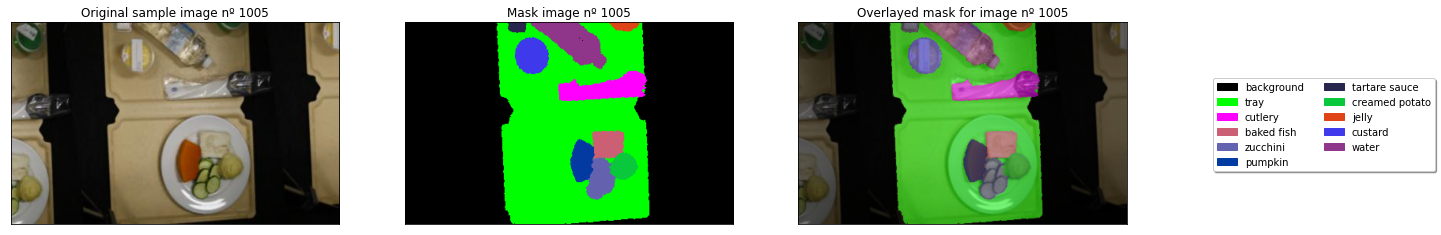

In [ ]:
imageIdx = random.randint(0,len(train_img_paths)-1)
image = np.array(load_img(train_img_paths[imageIdx]))
mask = np.array(load_img(train_mask_paths[imageIdx], color_mode="grayscale"))
titles = [f"Original sample image nº {imageIdx}",f"Mask image nº {imageIdx}",f"Overlayed mask for image nº {imageIdx}"]
plot_segmentations(image, mask, titles=titles)

> Here we can see a sample image with its corresponding mask and this last one overlayed in front of the original image. We can see that some of the food is being segmented while (in some random images) some of the food is not located.

# Image Generator

*   Create an image generator class (similar to the tutorial) to iterate over the images and return a tuple corresponding to the batch number.
*   The generator should inherit from the Sequence class.
*   It should have \_\_init\_\_(), \_\_len\_\_() and \_\_getitem\_\_() methods.
*   The batch size, image size, image paths and mask paths should be initialized using the \_\_init\_\_ method.

In [ ]:
class ImageGenerator(keras.utils.Sequence):

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)
        return x, y

> This image generator reads images of a specific size (img_size) from the given input and target paths and returns batches of tuples of images and targets. This generator is nearly identical to the one in the tutorial, but it did not extract one from the target images.

# U-Net Xception-style model

*   We will use the same model architecture that we followed in the tutorial for this exercise

In [ ]:
def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model

> This model is entirely extracted from the tutorial.\
We can see that it is a U-Net, with the first part being a contraction phase followed by the second, an expansion phase.

In [ ]:
keras.backend.clear_session()
model = get_model(img_size, num_classes)

*   Print the summary of the model

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 80, 80, 32)   896         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 80, 80, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

> We can see that the model has a lot of layers. Some of them are convolutional layers, which intercalate with batch normalization, max_pooling for the contraction phase, up_sampling for the expansion phase, and activation layers, among others. It has to be mentioned that this is quite a big model with a total of 2 million parameters, most of them having to be trained.

# Instantiate Image Generators for each split

*   For this experiment, we will use the test split as the validation generator

In [ ]:
random.Random(1337).shuffle(train_img_paths)
random.Random(1337).shuffle(train_mask_paths)

train_gen = ImageGenerator(batch_size, img_size, train_img_paths, train_mask_paths)
val_gen = ImageGenerator(batch_size, img_size, test_img_paths, test_mask_paths)

# Train Model

*   Configure the model for training
    *   Use 'Sparse Categorical Crossentropy' loss for training
    *   Use 'rmsprop' optimizer

In [ ]:
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

*   Instantiate a ModelCheckpoint callback to save only the best model

In [ ]:
callbacks = [keras.callbacks.ModelCheckpoint("oxford_segmentation.h5", save_best_only=True)]

*   Train the model using fit method

> We have saved the model as "imageSegmentationModel.h5". If you want to retrain the model, set train to true and load to false to use the trained model. This new model can also be saved if the save boolean indicates so.

In [ ]:
train, save, load = False, False, True
saveLoadPath = root_path+'imageSegmentationModel.h5'

if train:
  print("Train model...", end="")
  model.fit(train_gen, epochs=15, validation_data=val_gen, callbacks=callbacks)
  print("Done!")
if train and save:
  print("Save model...", end="")
  model.save(saveLoadPath)
  print("Done!")
if load:
  print("Loading model...", end="")
  model = keras.models.load_model(saveLoadPath)
  print("Done!")

Loading model...Done!


# Visualize predictions

*   Generate predictions for all images in the validation set
*   The mask is determined by the maximum value along the final axis. For all the predictions get the value of the predicted mask.
*   Read the test mask images to create the ground truth

In [ ]:
batch_size = 1  # we define batch_size as 1 for inferencing
val_gen = ImageGenerator(batch_size, img_size, test_img_paths, test_mask_paths)

In [ ]:
val_images = []
val_masks = []
val_images_pred = []
for val_image, val_mask in val_gen:
  val_images.append(val_image[0].astype("int"))
  val_masks.append(val_mask[0].squeeze())
  pred = model.predict(val_image)
  val_images_pred.append(pred[0])

val_images = np.array(val_images)
val_masks = np.array(val_masks)
val_images_pred = np.array(val_images_pred)

# Compute tha maximum value of last axis to get the predicted mask
val_masks_pred = np.argmax(val_images_pred, axis=-1)

print("Images shape", val_images.shape)
print("Masks shape", val_masks.shape)
print("Predictions shape", val_images_pred.shape)
print("Predictions masks shape", val_masks_pred.shape)

1/1 [==============================] - 0s 28ms/step
Images shape (8, 160, 160, 3)
Masks shape (8, 160, 160)
Predictions shape (8, 160, 160, 43)
Predictions masks shape (8, 160, 160)


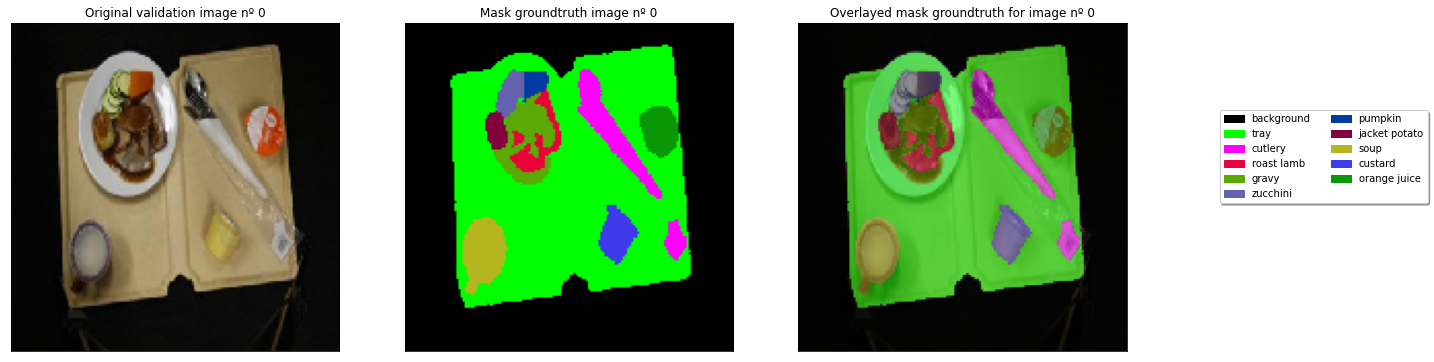

In [ ]:
imageIdx = 0 # First image
titles = [f"Original validation image nº {imageIdx}",f"Mask groundtruth image nº {imageIdx}",f"Overlayed mask groundtruth for image nº {imageIdx}"]
plot_segmentations(val_images[imageIdx], val_masks[imageIdx], titles=titles)

> We can see that the ground truth mask has a lot of interesting parts where food is being correctly segmented. This image contains 11 different colors, ranging from the black background to the orange juice in dark green, passing through the cuttlery or the soup.

*   For each validation image, find the jaccard similarity score

In [ ]:
averages = ['micro', 'macro', 'samples', 'weighted', 'binary', None]

print("Jaccard similarity coefficient score:")
for average in averages:
  print(" Average =",average)
  for imageIdx, (val_mask, val_mask_pred) in enumerate(zip(val_masks, val_masks_pred)):
    try:
      jaccard = jaccard_score(val_mask.flatten(), val_mask_pred.flatten(), average=average)
    except:
      print("  Not possible to use average =", average)
      break
    print(f"  Image {imageIdx+1} =", jaccard)

Jaccard similarity coefficient score:
 Average = micro
  Image 1 = 0.817923590399091
  Image 2 = 0.9463240325401049
  Image 3 = 0.7516250427642833
  Image 4 = 0.9477308175143607
  Image 5 = 0.8263537133480774
  Image 6 = 0.8552741239989854
  Image 7 = 0.8587090684672911
  Image 8 = 0.9495849516411545
 Average = macro
  Image 1 = 0.41490911437650224
  Image 2 = 0.8423212113582805
  Image 3 = 0.2437052871993086
  Image 4 = 0.8246175632944776
  Image 5 = 0.34275308751878286
  Image 6 = 0.552177862354996
  Image 7 = 0.45830306471678944
  Image 8 = 0.8533780527113942
 Average = samples
  Not possible to use average = samples
 Average = weighted
  Image 1 = 0.855585505041654
  Image 2 = 0.9473588514826423
  Image 3 = 0.7777418924450176
  Image 4 = 0.9505766335636906
  Image 5 = 0.8475730483672702
  Image 6 = 0.8650385207975211
  Image 7 = 0.864164571561474
  Image 8 = 0.9510056576283005
 Average = binary
  Not possible to use average = binary
 Average = None
  Image 1 = [0.9771345  0.8435737

*   Randomly display one image, groundtruth mask, overlayed groundtruth mask, prediction mask, overlayed prediction mask using matplotlib 

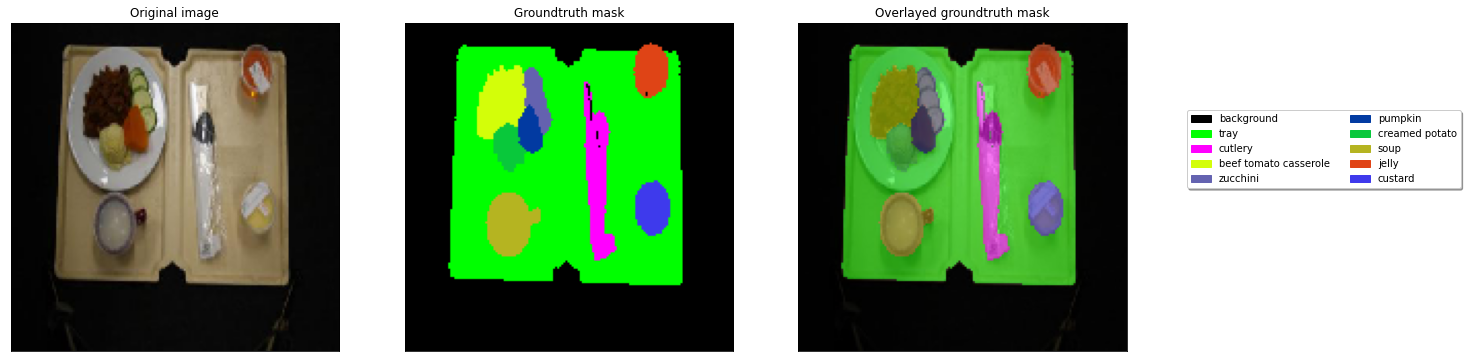

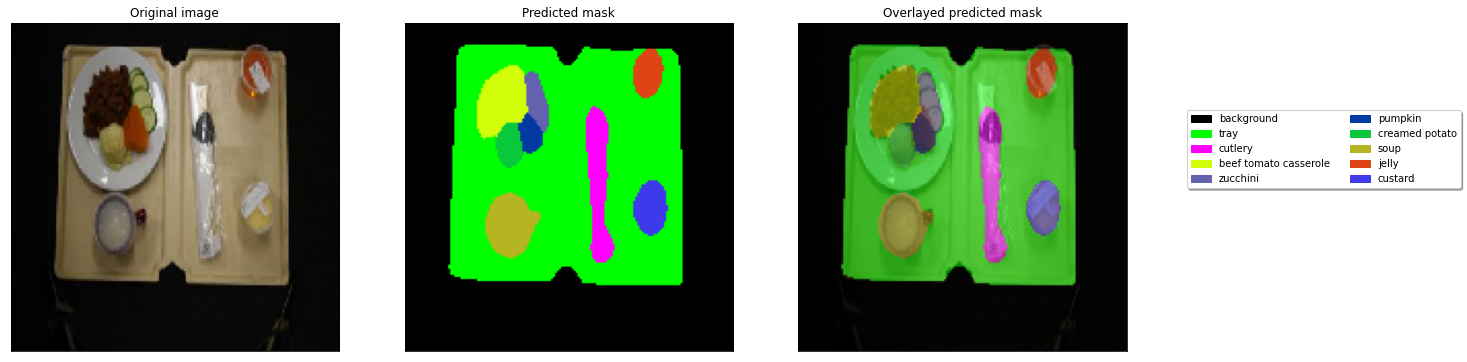

In [ ]:
randomIdx = random.randint(0,len(val_images)-1)
val_image = val_images[randomIdx].astype('int')
val_mask = val_masks[randomIdx]
val_image_mask_pred = val_masks_pred[randomIdx]

titles = ["Original image", "Groundtruth mask", "Overlayed groundtruth mask"]
plot_segmentations(val_image, val_mask, titles)

titles = ["Original image", "Predicted mask", "Overlayed predicted mask"]
plot_segmentations(val_image, val_image_mask_pred, titles)

> We can see how all the elements located in the ground truth are being correctly found, segmented, and classified in the prediction mask. This shows the correctness of the model with images similar to the ones it was trained with.

# Testing Model in the wild

*   Download 5 images from the internet similar to the dataset used.
*   Use the trained model to segment the images

1/1 [==============================] - 0s 21ms/step


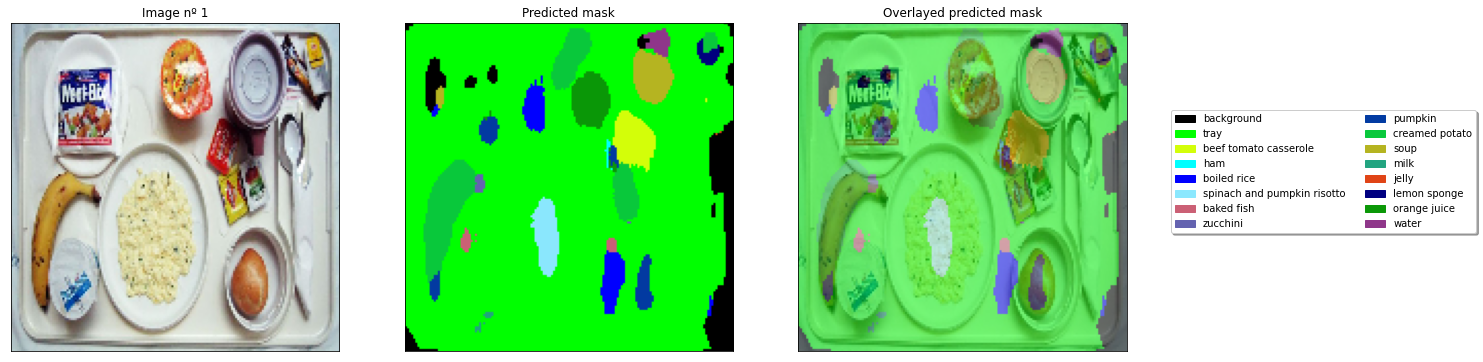

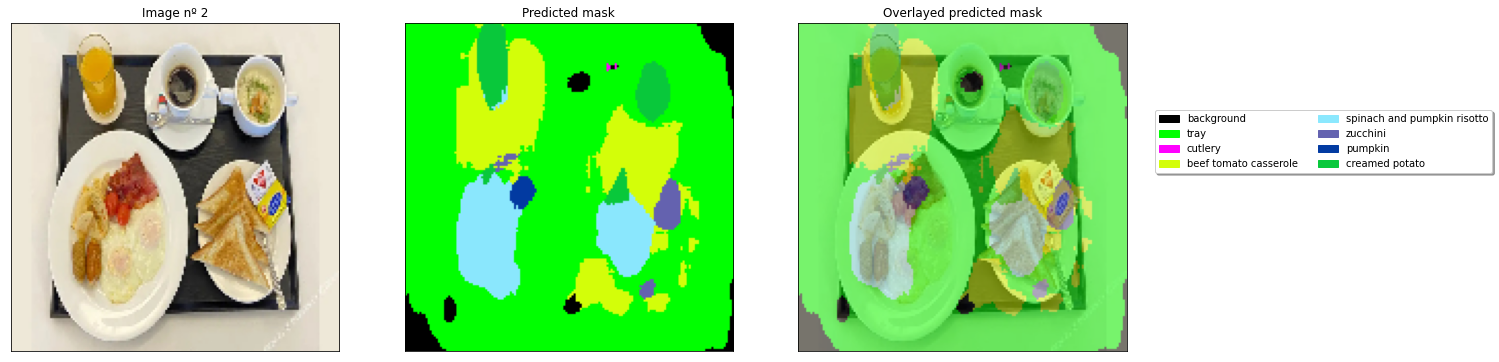

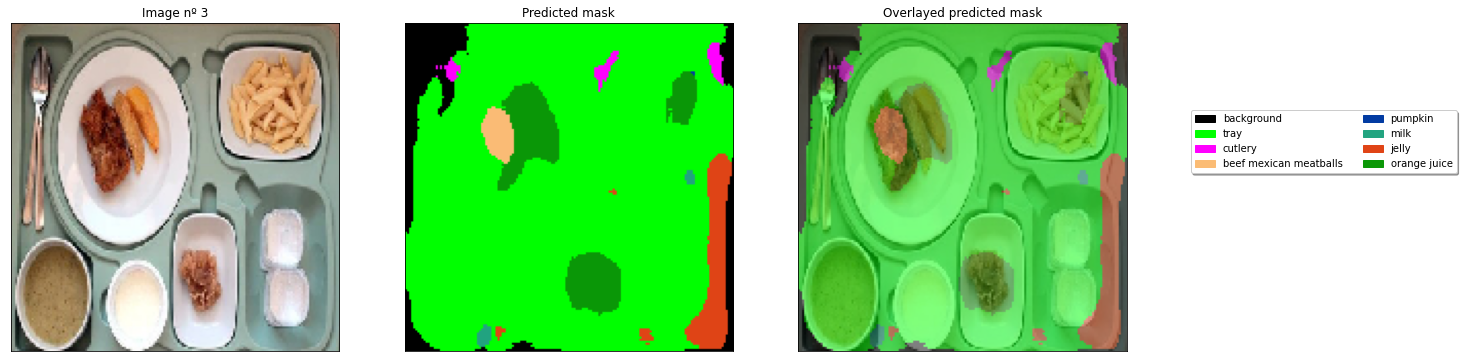

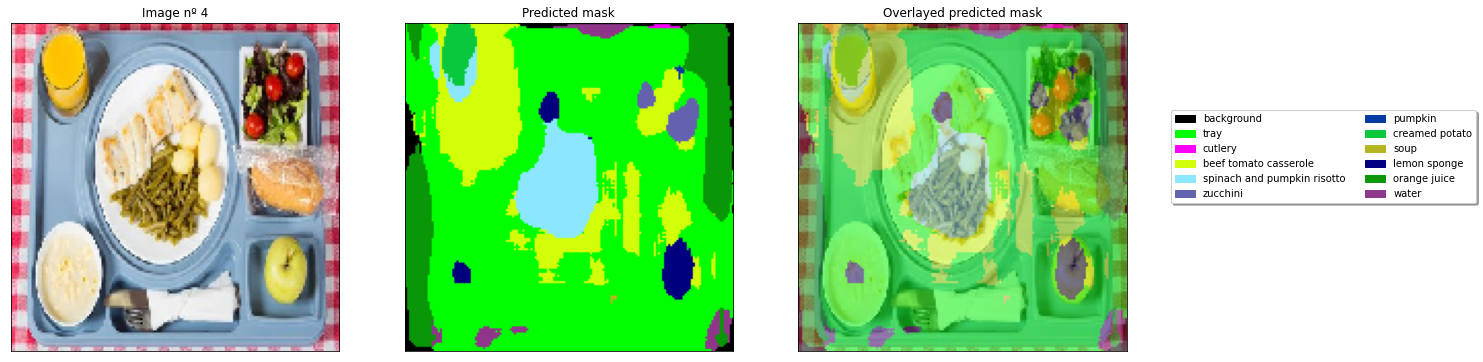

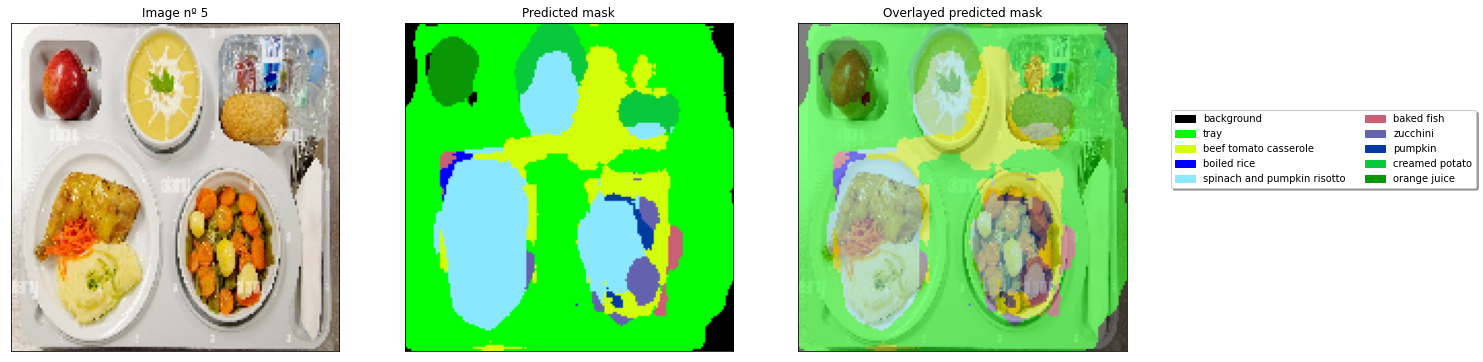

In [ ]:
sample_images_path = root_path+"sampleImages/"
sampleImages = []
for fname in sorted(os.listdir(sample_images_path)):
    image = load_img(sample_images_path+fname, target_size=img_size)
    sampleImages.append(np.array(image))
sampleImages = np.array(sampleImages)
predictions = model.predict(sampleImages)

for i, (image, prediction) in enumerate(zip(sampleImages, predictions)):
  titles = [f"Image nº {i+1}", "Predicted mask", "Overlayed predicted mask"]
  mask =  np.argmax(prediction, axis=-1)
  plot_segmentations(image, mask, titles=titles)

### Remember:

> 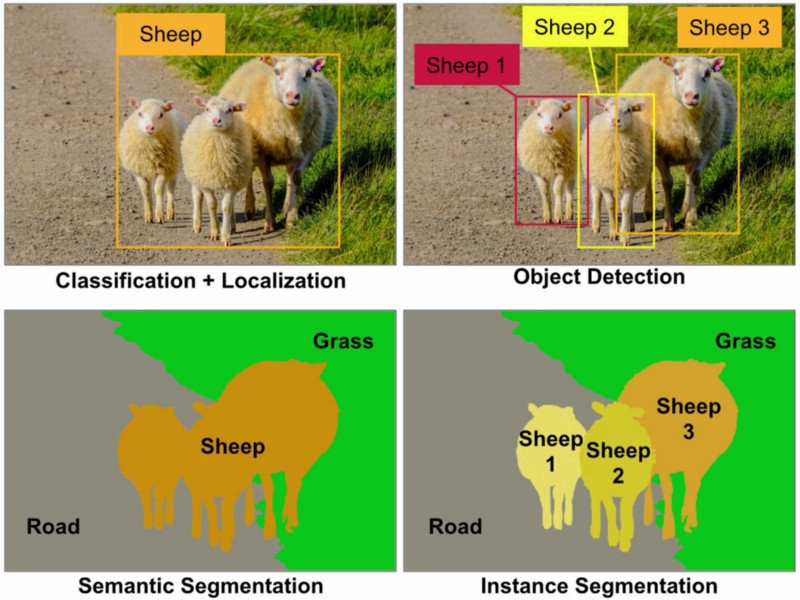

> [Image reference](https://nirmalamurali.medium.com/image-classification-vs-semantic-segmentation-vs-instance-segmentation-625c33a08d50)